In [14]:
import os #  using Python to interact with the operating system
from glob import glob #find all the pathnames matching a specified pattern according to the rules used by the Unix shell
import numpy as np
import cv2 # read image

import torch # work with PyTorch, a  deep learning library
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
#
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp #smp library is a collection of pre-trained models for image segmentation
import albumentations as A # image augmentation library that can be used to perform various image transformations.
from albumentations.pytorch import ToTensorV2 #The ToTensorV2 transform from albumentations.pytorch is used to convert images and masks to PyTorch tensors

import skimage # a collection of algorithms for image processing
!pip install torchmetrics
import torchmetrics
from torchmetrics import Dice, JaccardIndex

from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:

class SegmentationDataset(Dataset):
    """Generate Semantic Segmentation Dataset through the following steps:
      - Read images/ masks from path_name
      - Apply augmentations and Normalization
      - Process transformations
    Input:
        Dataset (image): Images
    Output: Dataset with transformed_image, transformed_mask (if transformation is applied)
     or image_tensor, mask_tensor (if transformation is not applied)  in tensor type
    """
    def __init__(self, path_name, transform=None):
        super().__init__()
        self.transform = transform
        self.image_names = os.listdir(f"{path_name}/images")
        self.image_paths = [f"{path_name}/images/{i}" for i in self.image_names]
        self.masks_names = os.listdir(f"{path_name}/masks")
        self.masks_paths = [f"{path_name}/masks/{i}" for i in self.masks_names]

        # Check and save only images and masks that are existing in equivalent folders
        self.img_stem = [Path(i).stem for i in self.image_paths]
        self.msk_stem = [Path(i).stem for i in self.masks_paths]
        self.img_msk_stem = set(self.img_stem) & set(self.msk_stem)
        self.image_paths = [i for i in self.image_paths if (Path(i).stem in self.img_msk_stem)]


    def __len__(self):
        return len(self.img_msk_stem)

    def __getitem__(self, index):

        image = cv2.imread(self.image_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask =  cv2.imread(self.masks_paths[index], cv2.IMREAD_GRAYSCALE)
        mask[mask >=2]= 1 # if boundary >= 2, then convert its pixel value to 1
        if self.transform is not None:
         transformed = self.transform(image = image, mask=mask)
         transformed_image = transformed['image']
         transformed_mask = transformed['mask']
         return transformed_image, transformed_mask
        else:
         image = image.transpose((2, 0, 1))  #structure: BS, C, H, W
         image_tensor = torch.tensor(image)
         mask_tensor = torch.tensor(mask)
         return image_tensor, mask_tensor

In [16]:
# Image Augementations and Normalization through Transformation
trainsize =256
train_transform = A.Compose([A.Resize(width = trainsize, height= trainsize), A.HorizontalFlip(),
                             A.RandomBrightnessContrast(),A.Blur(), A.RGBShift(),
                             A.Sharpen(),
                             A.Normalize (mean =(0.485,0.456,0.406), std =(0.229,0.224,0.225), max_pixel_value=255.0),ToTensorV2()])
val_transform = A.Compose([A.Resize(width = trainsize, height= trainsize),A.Normalize (mean =(0.485,0.456,0.406), std =(0.229,0.224,0.225), max_pixel_value=255.0),ToTensorV2()])

In [17]:
import torch
import torch.nn as nn

# Convolution + ReLU layers computation
def unet_layer(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True))

# Construct U-net model
class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()
        self.n_classes = n_classes

        # Define Downsampling layer
        self.downsample = nn.MaxPool2d(2)

        # Define convolution + ReLU layers in encoder path
        self.layer_down1 = unet_layer(3, 64)
        self.layer_down2 = unet_layer(64, 128)
        self.layer_down3 = unet_layer(128, 256)
        self.layer_down4 = unet_layer(256, 512)

        #
        self.layer_neck = unet_layer(512, 1024)

        # Define upsampling blocks with transposed convolutions
        self.upsample1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.upsample2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.upsample3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.upsample4 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)

        # Define convolution + ReLU layers in decoder path
        self.layer_up1 = unet_layer(1024, 512)
        self.layer_up2 = unet_layer(512, 256)
        self.layer_up3 = unet_layer(256, 128)
        self.layer_up4 = unet_layer(128, 64)

        # Segmentation output map
        self.conv_cls = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder Path with 2 Convolutions and Downsampling
        out1 = self.layer_down1(x)
        x = self.downsample(out1)
        out2 = self.layer_down2(x)
        x = self.downsample(out2)
        out3 = self.layer_down3(x)
        x = self.downsample(out3)
        out4 = self.layer_down4(x)
        x = self.downsample(out4)

        # Bottleneck layer
        x = self.layer_neck(x)

        # Decoder Path with Upsampling, Concatenating and Convolutions
        x = self.upsample1(x)
        x = torch.cat([out4, x], dim=1)
        x = self.layer_up1(x)

        x = self.upsample2(x)
        x = torch.cat([out3, x], dim=1)
        x = self.layer_up2(x)

        x = self.upsample3(x)
        x = torch.cat([out2, x], dim=1)
        x = self.layer_up3(x)

        x = self.upsample4(x)
        x = torch.cat([out1, x], dim=1)
        x = self.layer_up4(x)

        # Final classification layer
        x = self.conv_cls(x)
        return x


In [18]:
class AverageMeter(object):
    """This class for keeping track of the average value of a metric (e.g., loss, accuracy, IOU, DICE) over multiple batches or epochs."""

    def __init__(self):
        self.reset()

    def reset(self):
        """Reset all meters"""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """Updates the meter with a new value"""
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Accuracy Function
"""This function is used for measuring the nf1 severity in the given image"""
def nf1_density(mask):
    total_area = mask.size(0)*mask.size(1) # calculate the to the total number of pixels in the 2D mask
    mask = mask.flatten() # Flatten the mask to a 1D tensor
    nf1 = torch.sum(mask == 1)  # Count the number of pixels where NF1 is present
    density = (nf1/total_area)*100 # Calculate the density as a percentage
    return density

In [19]:
# Define Class
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self,tensor):
        """
        Args: tensor(Tensor): Tensor image of size (C,H, W) to be un-normalized.
        Returns:
        Tensor: Un-Normolized image'
        """
        # mean and std are converted to tensors and then unsqueezed to match the dimensions of the tensor
        mean = torch.tensor(self.mean).unsqueeze(-1).unsqueeze(-1)
        std = torch.tensor(self.std).unsqueeze(-1).unsqueeze(-1)
        unnorm_tensor = tensor.clone()  # To avoid modifying the original tensor
        unnorm_tensor.mul_(std).add_(mean)
        return unnorm_tensor

In [20]:
# Check device for training
device = "cuda" if torch.cuda.is_available() else "cpu"

# Binary Classification with Unet model
model = UNet(1).to(device)

# Define the path to the test folder
# Return the current working directory (CWD) of the script that is being executed
root_path = os.getcwd()  
print(root_path)

# Call the path leading to the folder of validation dataset which is test_256
root_path_val = root_path +'/test_All'+'/test_256'

# BS =1 to handle one image at a time 
# to accurately measure performance metrics like IoU, DICE for each image processing 
BS = 1

# Generate Validation Dataset and Dataloader
val_dataset = SegmentationDataset(path_name= root_path_val,transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=BS, shuffle=False)

print(len(val_dataset)) # the samples number of validation dataset 

c:\course22\Thesis_NF1Project_TuongHieuHuynh
63


In [21]:
# LOAD WEIGHTS FROM TRAINED MODEL

#Get the absolute path to the file
import torch
# Call the path where the trained model file is saved. Here it is save in "model" folder
file_path = os.path.abspath('model/model_ep584.pth')
print(file_path)

# Load the weights from trained_model
model.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))

c:\course22\Thesis_NF1Project_TuongHieuHuynh\model\model_ep584.pth


<All keys matched successfully>

In [22]:
# LOSS
# Define Binary Cross-Entropy Loss function
criterion = nn.BCEWithLogitsLoss()

# OPTIMIZER: Adam optimizer
optimizer = torch.optim.Adam(model.parameters(),lr =1e-4)

# EVALUATION FUNCTIONS: define DICE and IOU function from library
dice_function = torchmetrics.Dice(num_classes=2, average= "macro").to(device)
iou_function= torchmetrics.JaccardIndex(num_classes=2,task="binary", average= "macro").to(device)

#METER

# DICE and IOU METERS during validation
dice_meter = AverageMeter()

iou_meter =AverageMeter()

# NF1 SEVERITY MEASUREMENT METER during validation

density_meter = AverageMeter()


In [23]:
# Set model to evaluation mode
model.eval()
iou_record =[]
dice_record =[]

with torch.no_grad():
       for barch_id, (x,y) in enumerate (tqdm(val_dataloader),start =1):
        #print(barch_id)
        #print(x.shape) #(BS,C,H,W) =(1,3,256,256)
        #print(y.shape) # (BS,H,W) = (1, 256, 256)
        image = x.to(device).float()
        #y = y.to(device).float()
        pre_mask = model(image)
        pre_mask  = pre_mask .squeeze() 
        
        predicted_mask = pre_mask.sigmoid().round().long()
        y = y.squeeze()
        #print(y.shape)
        #print(predicted_mask.shape)
        
        # Calculate IOU score for each image sample process
        iou_score = iou_function(predicted_mask,y.long())
        iou_score=iou_score*100
        iou_record.append(iou_score)

        # Calculate DICE score for each image sample process
        dice_score = dice_function(predicted_mask,y.long())
        dice_score=dice_score*100
        dice_record.append(dice_score)
       
# Average IOU
total_sum1 = sum(iou_record)
total_elements1 = len(iou_record)
average1 = total_sum1 / total_elements1
printed_IOU = average1   
  
# Average DICE
total_sum2 = sum(dice_record)
total_elements2 = len(dice_record)
average2 = total_sum2 / total_elements2
printed_DICE = average2 

print("Validation mode: Average IoU in % ={}".format(printed_IOU))
print("Validation mode: Average Dice in %={}".format(printed_DICE))

100%|██████████| 63/63 [00:49<00:00,  1.28it/s]

Validation mode: Average IoU in % =59.02812957763672
Validation mode: Average Dice in %=85.23871612548828


Index: 0
IOU SCORE in 100%: IoU=58.23986053466797
DICE SCORE in 100%: Dice=86.4249038696289


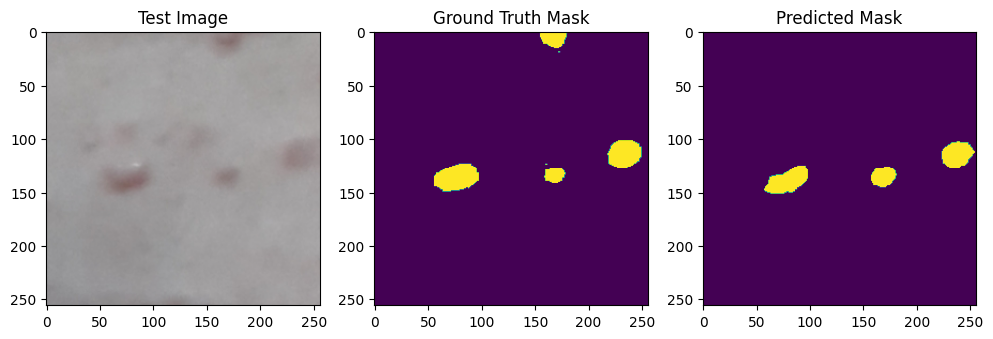

Index: 1
IOU SCORE in 100%: IoU=11.094282150268555
DICE SCORE in 100%: Dice=59.07016372680664


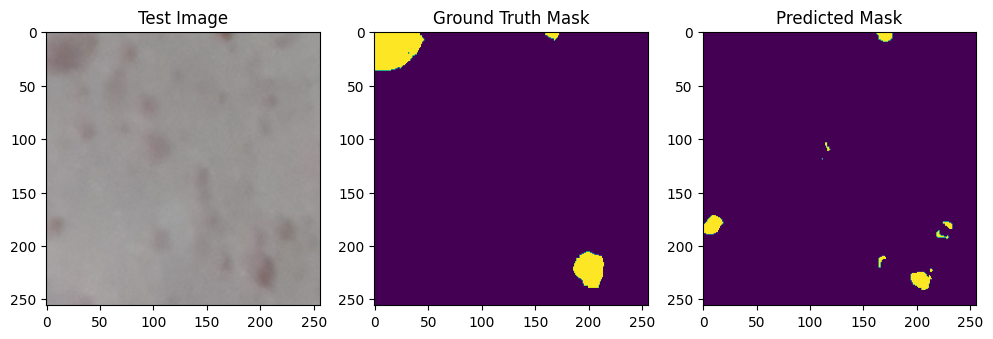

Index: 2
IOU SCORE in 100%: IoU=76.42740631103516
DICE SCORE in 100%: Dice=93.2073745727539


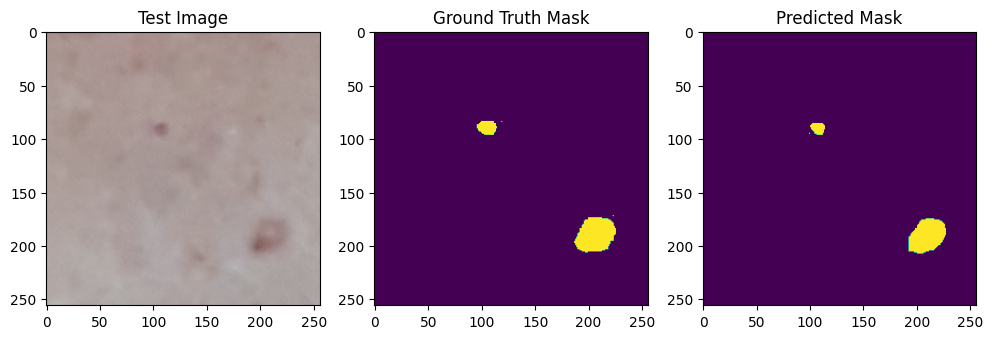

Index: 3
IOU SCORE in 100%: IoU=63.52313232421875
DICE SCORE in 100%: Dice=88.68794250488281


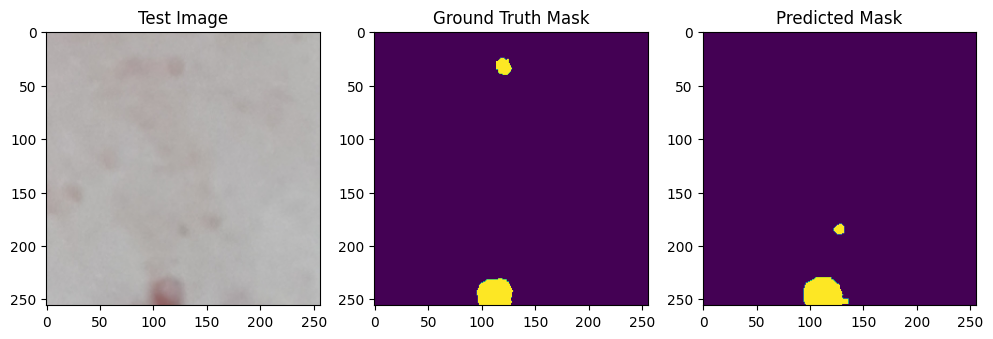

Index: 4
IOU SCORE in 100%: IoU=80.24809265136719
DICE SCORE in 100%: Dice=94.18572998046875


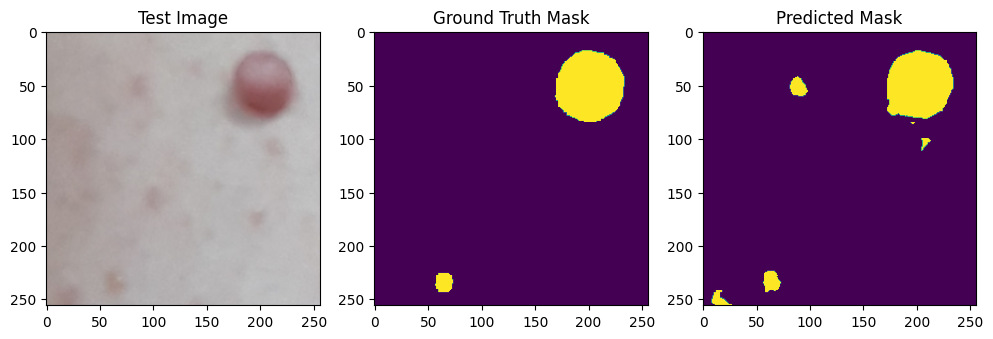

Index: 5
IOU SCORE in 100%: IoU=78.525634765625
DICE SCORE in 100%: Dice=93.95996856689453


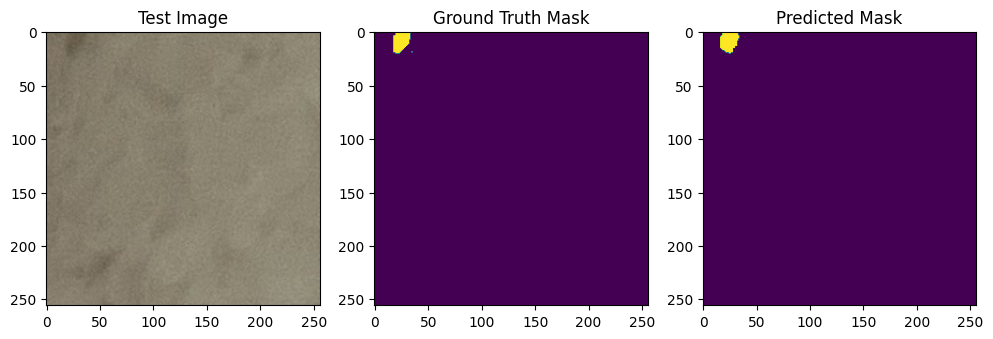

Index: 6
IOU SCORE in 100%: IoU=66.73387145996094
DICE SCORE in 100%: Dice=89.83171844482422


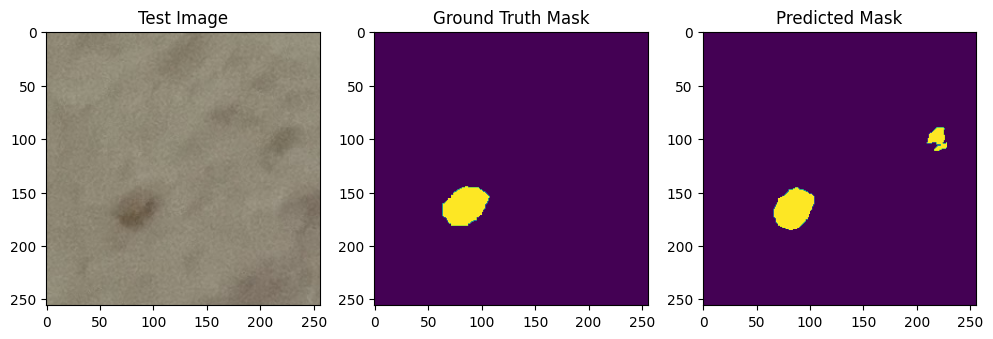

Index: 7
IOU SCORE in 100%: IoU=80.10948944091797
DICE SCORE in 100%: Dice=94.12425231933594


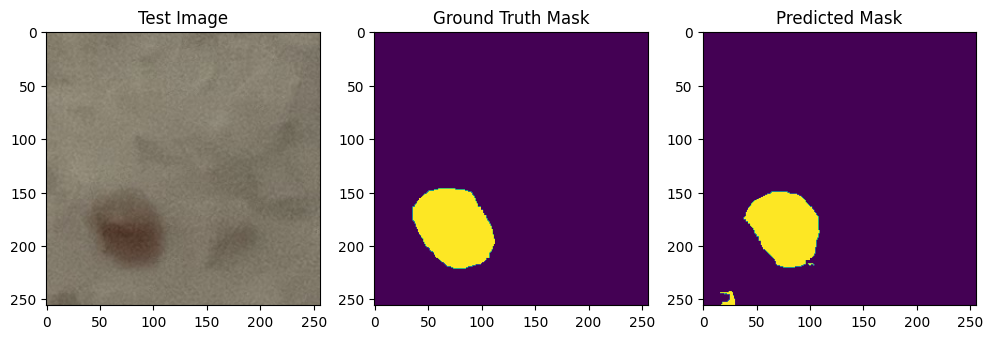

Index: 8
IOU SCORE in 100%: IoU=0.0
DICE SCORE in 100%: Dice=49.685611724853516


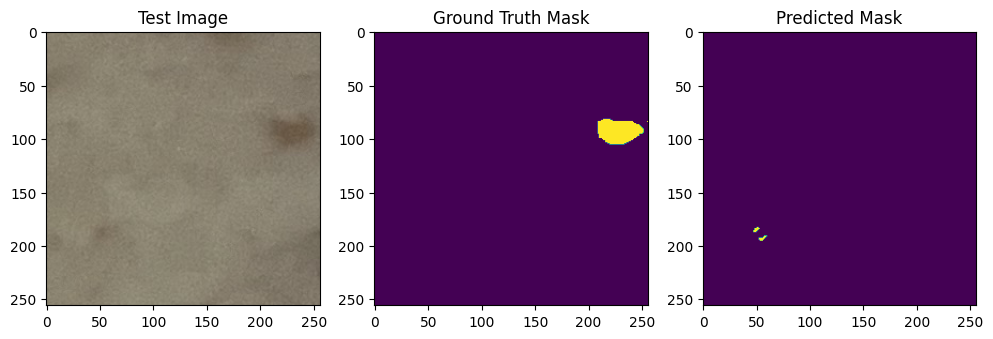

Index: 9
IOU SCORE in 100%: IoU=51.6732292175293
DICE SCORE in 100%: Dice=83.87925720214844


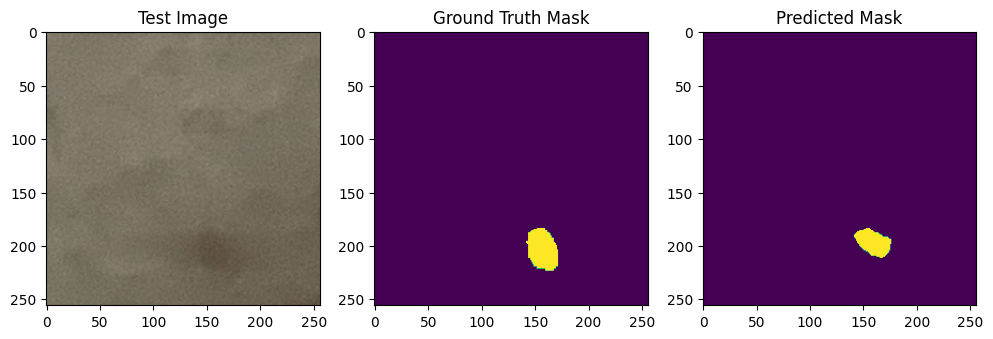

Index: 10
IOU SCORE in 100%: IoU=47.27510070800781
DICE SCORE in 100%: Dice=80.95317840576172


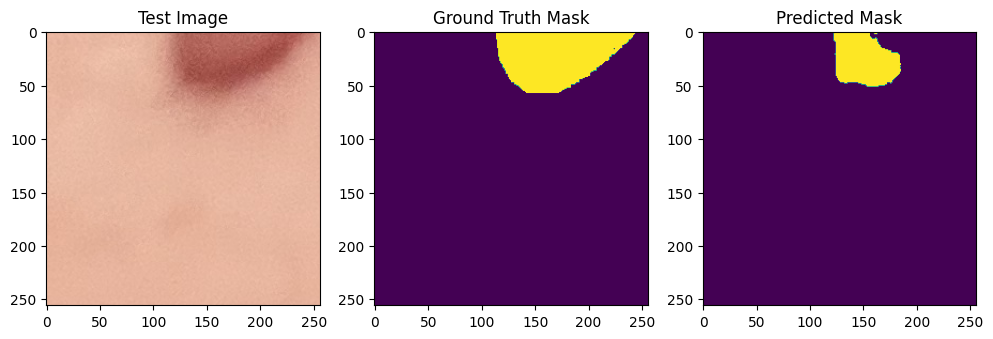

Index: 11
IOU SCORE in 100%: IoU=70.51372528076172
DICE SCORE in 100%: Dice=91.0217514038086


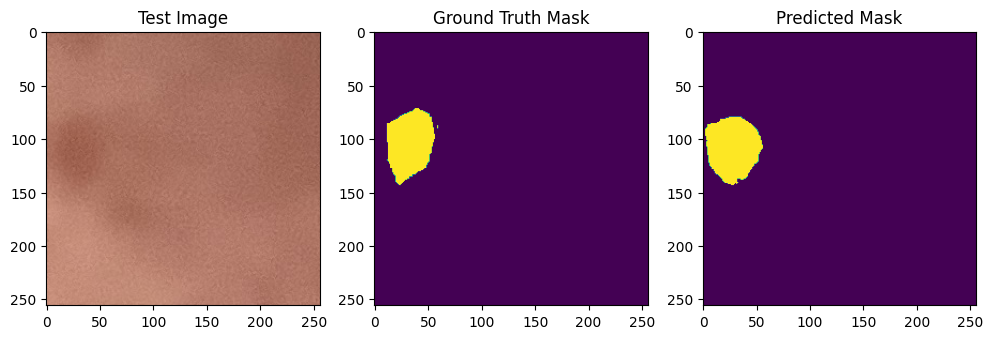

Index: 12
IOU SCORE in 100%: IoU=63.6866340637207
DICE SCORE in 100%: Dice=88.27201080322266


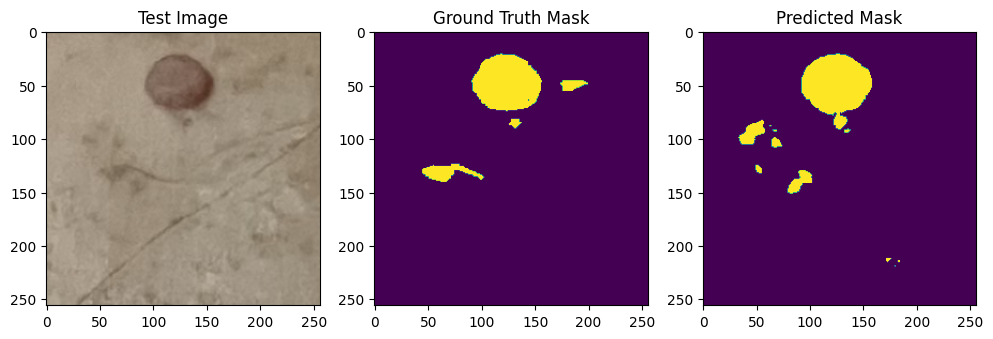

Index: 13
IOU SCORE in 100%: IoU=75.20901489257812
DICE SCORE in 100%: Dice=92.65522003173828


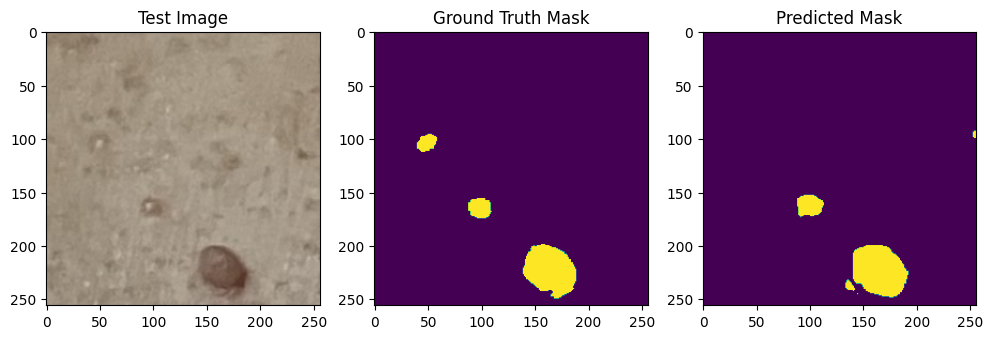

Index: 14
IOU SCORE in 100%: IoU=45.92825698852539
DICE SCORE in 100%: Dice=79.67535400390625


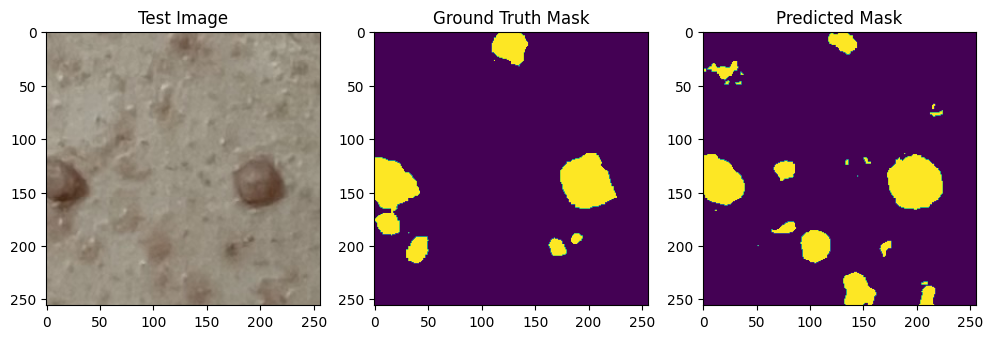

Index: 15
IOU SCORE in 100%: IoU=75.92780303955078
DICE SCORE in 100%: Dice=92.77711486816406


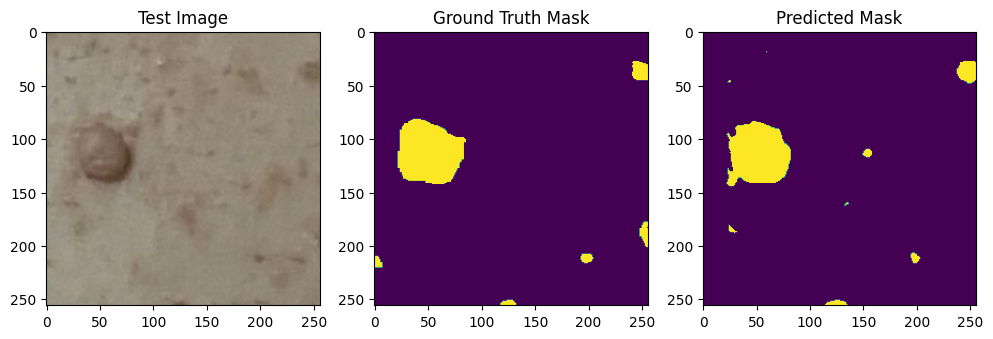

Index: 16
IOU SCORE in 100%: IoU=37.82658004760742
DICE SCORE in 100%: Dice=76.11863708496094


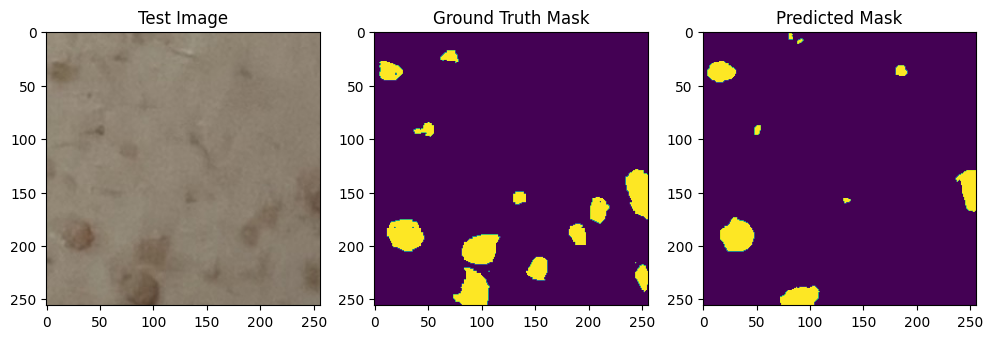

Index: 17
IOU SCORE in 100%: IoU=55.10600662231445
DICE SCORE in 100%: Dice=84.59049987792969


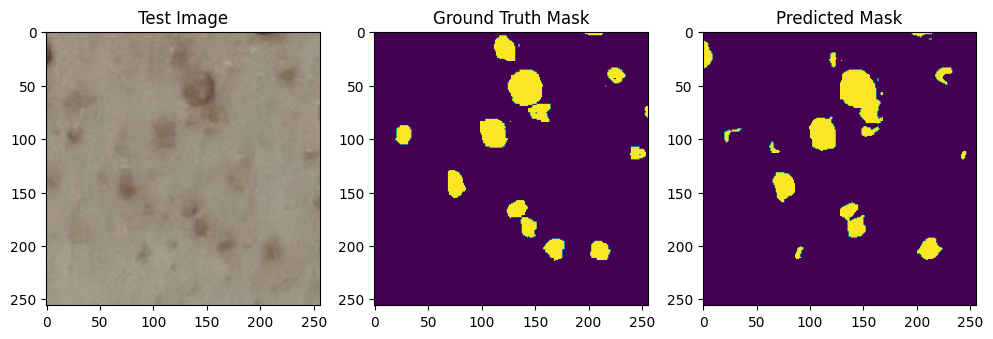

Index: 18
IOU SCORE in 100%: IoU=54.880950927734375
DICE SCORE in 100%: Dice=84.17790222167969


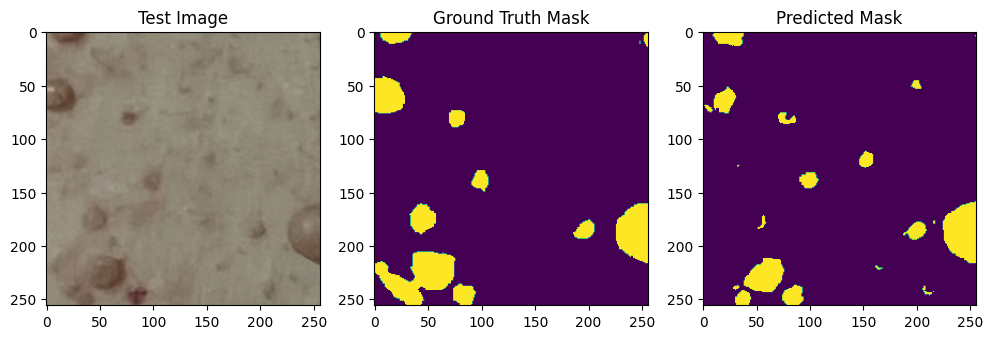

Index: 19
IOU SCORE in 100%: IoU=46.649444580078125
DICE SCORE in 100%: Dice=80.45596313476562


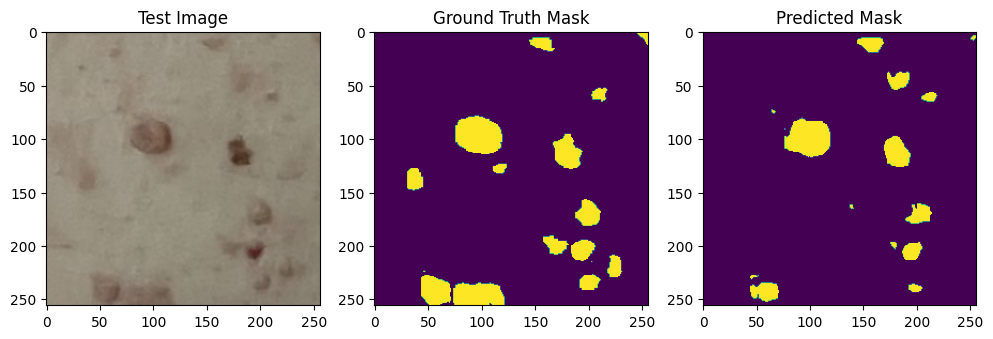

Index: 20
IOU SCORE in 100%: IoU=42.11552429199219
DICE SCORE in 100%: Dice=78.68653869628906


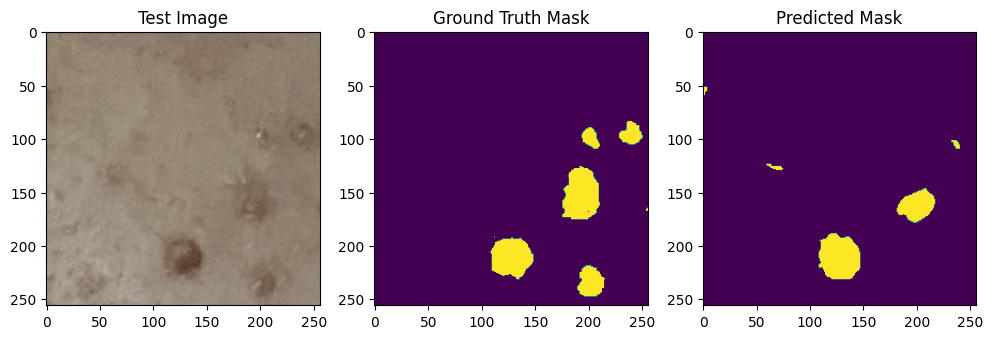

Index: 21
IOU SCORE in 100%: IoU=68.71426391601562
DICE SCORE in 100%: Dice=90.03268432617188


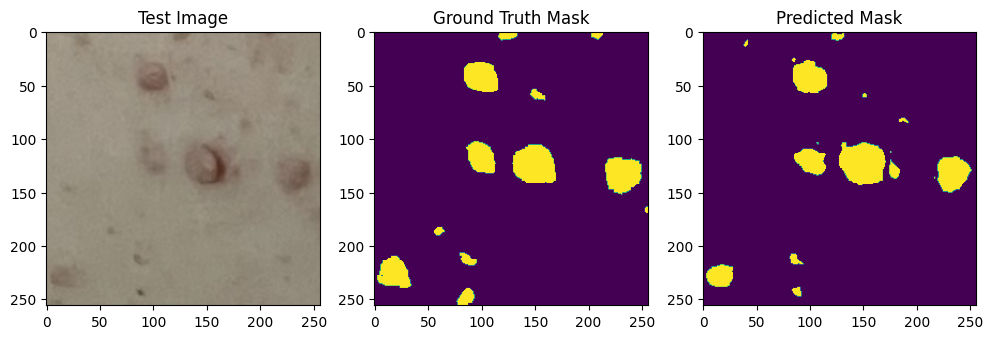

Index: 22
IOU SCORE in 100%: IoU=59.364009857177734
DICE SCORE in 100%: Dice=86.0970458984375


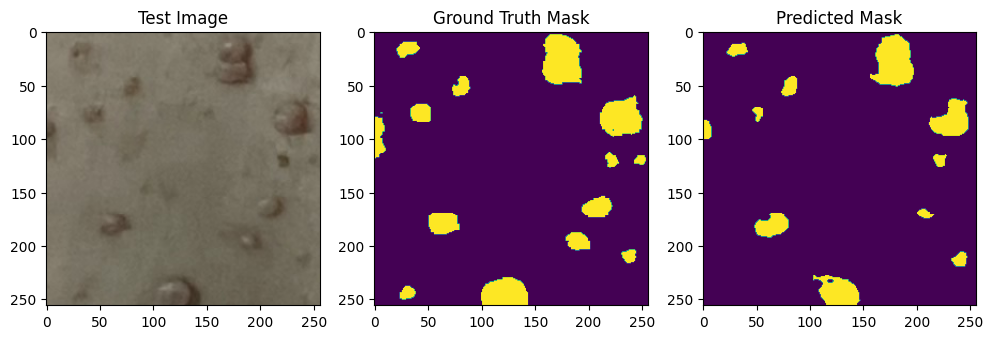

Index: 23
IOU SCORE in 100%: IoU=52.02702713012695
DICE SCORE in 100%: Dice=83.33541107177734


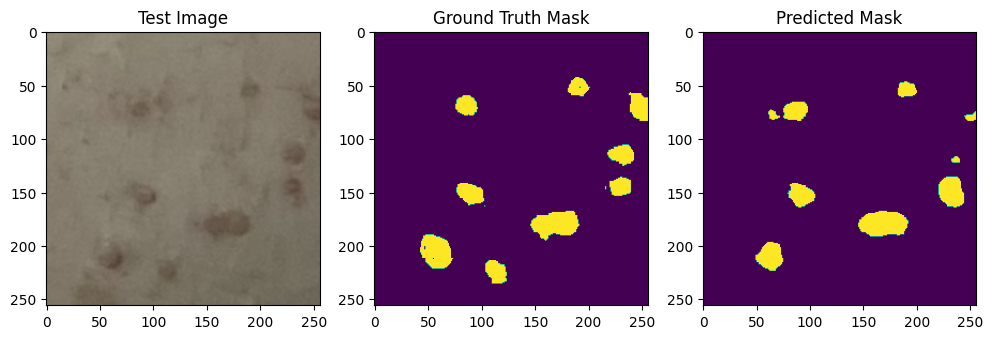

Index: 24
IOU SCORE in 100%: IoU=61.81305694580078
DICE SCORE in 100%: Dice=87.54560089111328


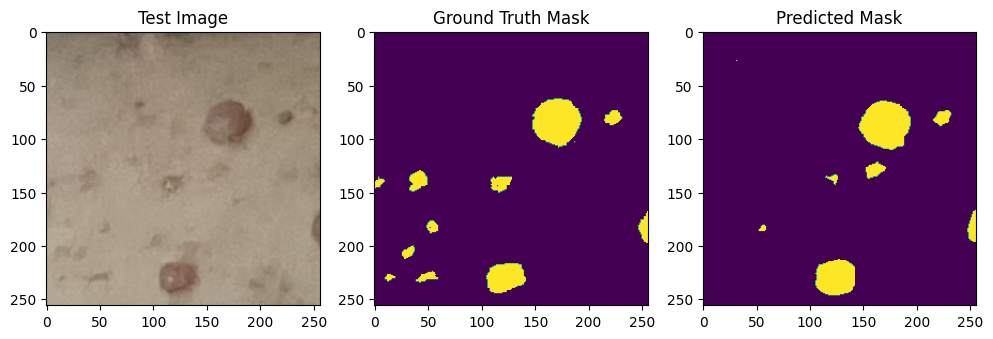

Index: 25
IOU SCORE in 100%: IoU=62.972373962402344
DICE SCORE in 100%: Dice=88.17698669433594


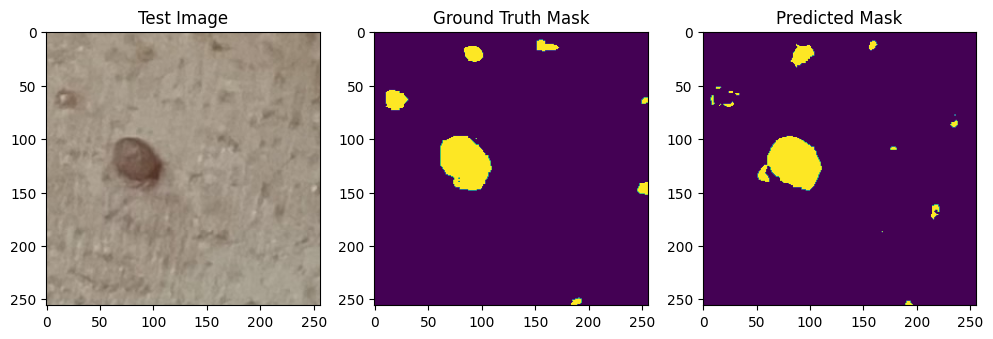

Index: 26
IOU SCORE in 100%: IoU=68.8013687133789
DICE SCORE in 100%: Dice=90.00720977783203


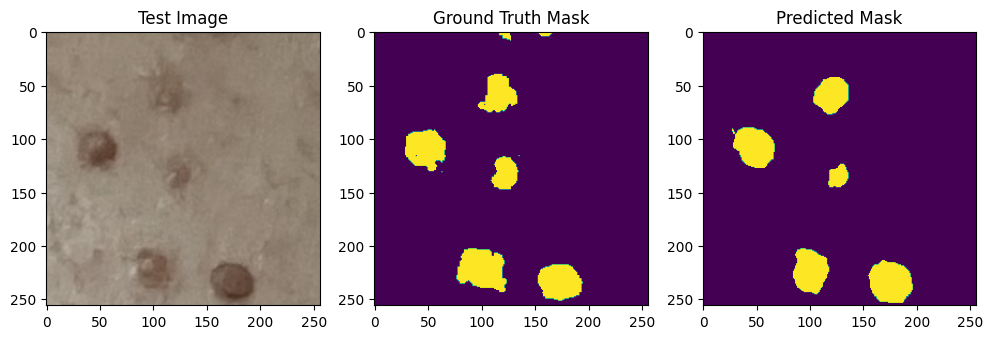

Index: 27
IOU SCORE in 100%: IoU=68.23918914794922
DICE SCORE in 100%: Dice=89.93653106689453


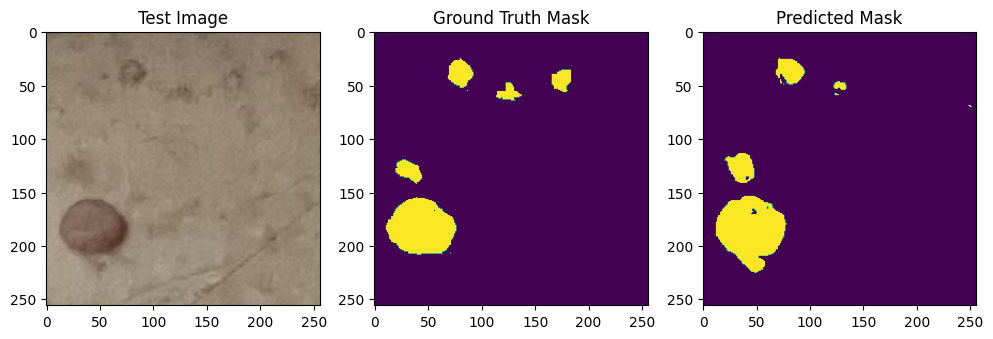

Index: 28
IOU SCORE in 100%: IoU=70.19287109375
DICE SCORE in 100%: Dice=91.0441665649414


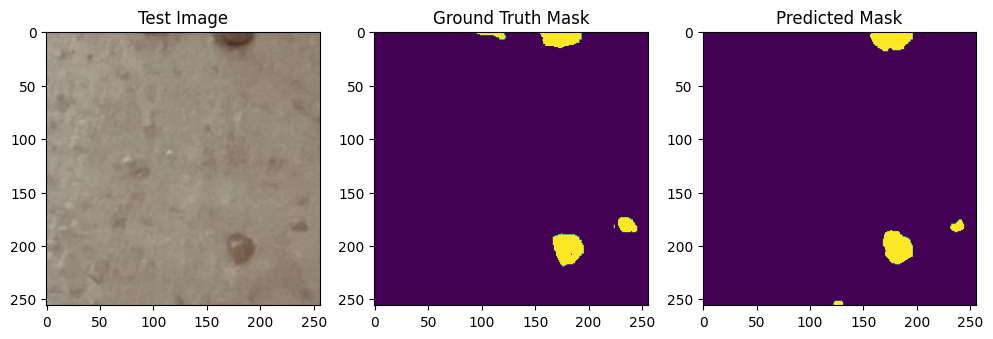

Index: 29
IOU SCORE in 100%: IoU=61.37049865722656
DICE SCORE in 100%: Dice=87.13887023925781


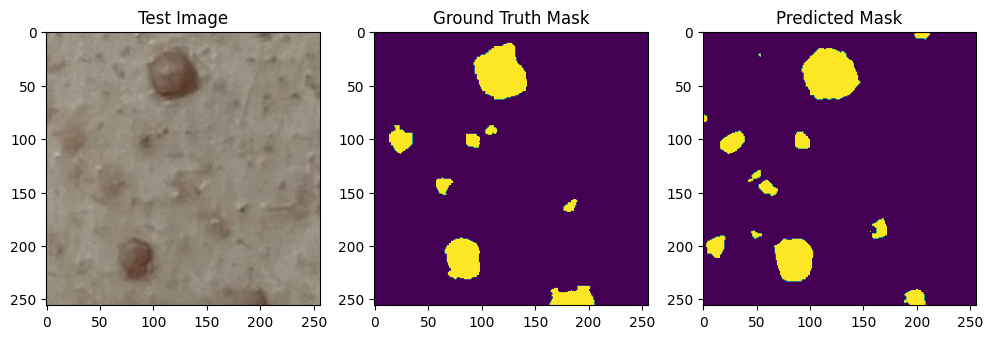

Index: 30
IOU SCORE in 100%: IoU=74.29306030273438
DICE SCORE in 100%: Dice=92.2652816772461


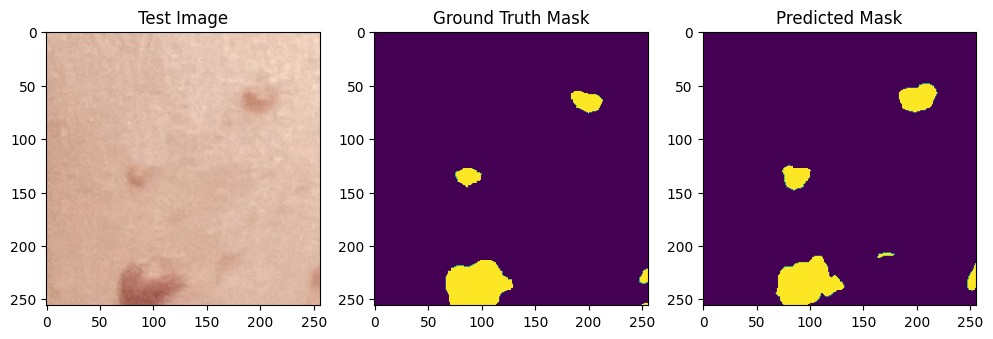

Index: 31
IOU SCORE in 100%: IoU=70.97645568847656
DICE SCORE in 100%: Dice=91.21551513671875


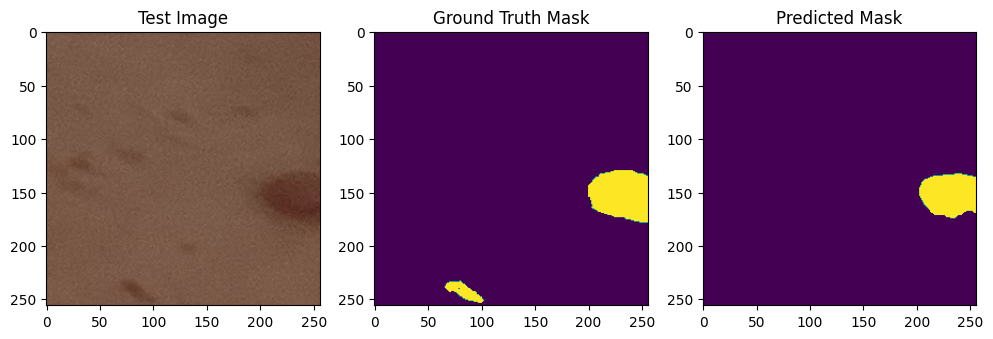

Index: 32
IOU SCORE in 100%: IoU=81.98258209228516
DICE SCORE in 100%: Dice=94.94490051269531


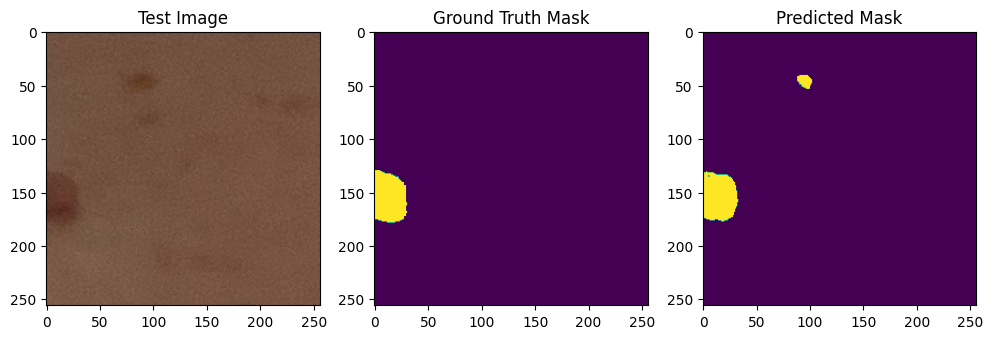

Index: 33
IOU SCORE in 100%: IoU=78.03228759765625
DICE SCORE in 100%: Dice=92.6491470336914


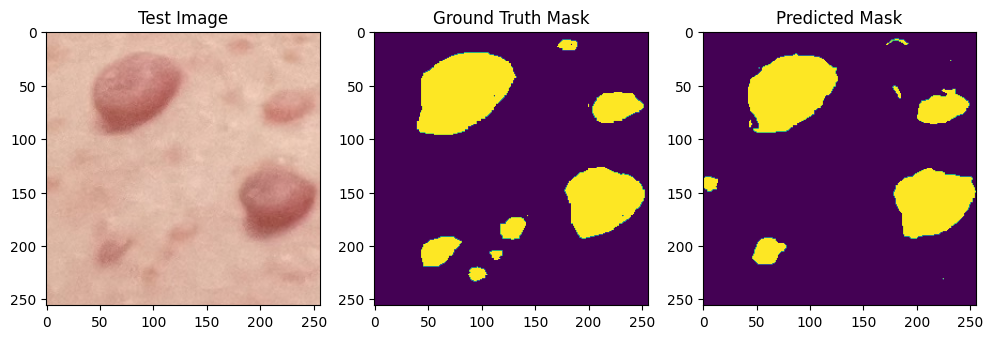

Index: 34
IOU SCORE in 100%: IoU=74.27385711669922
DICE SCORE in 100%: Dice=92.5714340209961


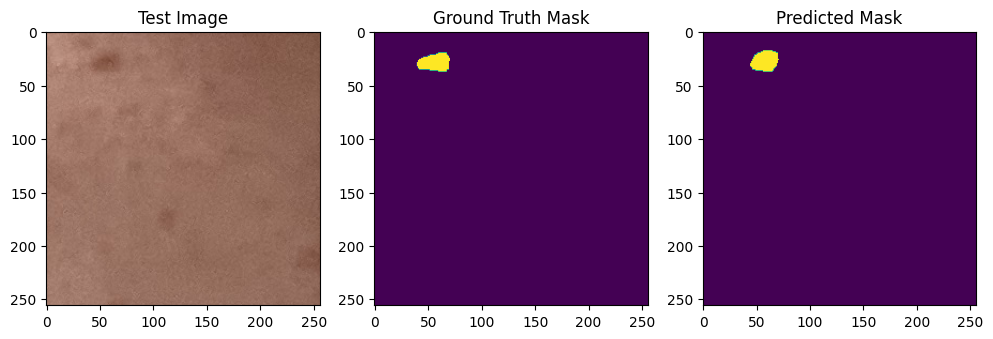

Index: 35
IOU SCORE in 100%: IoU=68.6186752319336
DICE SCORE in 100%: Dice=90.33358001708984


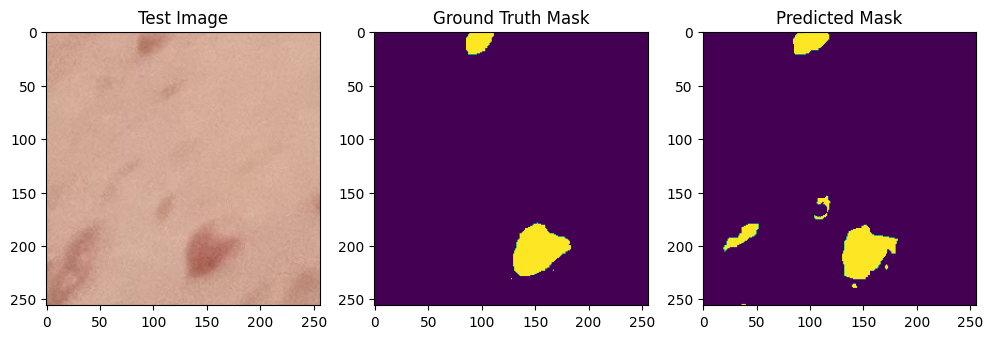

Index: 36
IOU SCORE in 100%: IoU=36.71613311767578
DICE SCORE in 100%: Dice=76.3402099609375


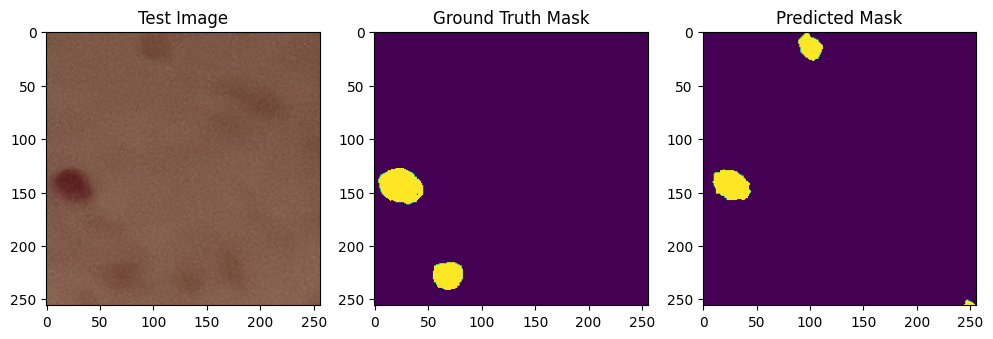

Index: 37
IOU SCORE in 100%: IoU=72.31822967529297
DICE SCORE in 100%: Dice=91.2632827758789


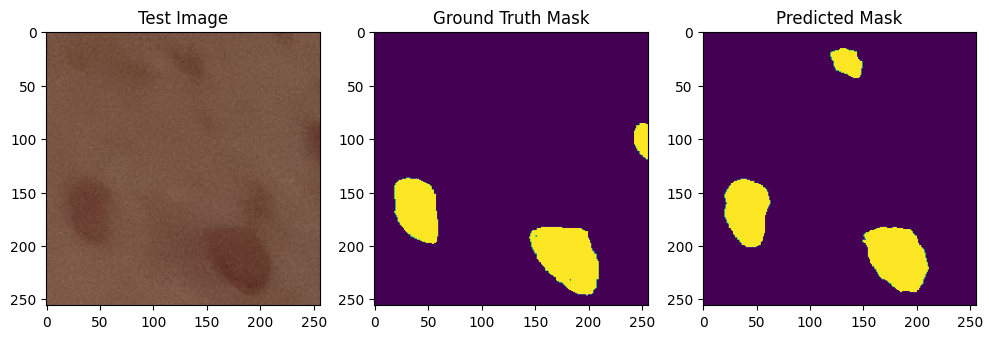

Index: 38
IOU SCORE in 100%: IoU=41.006752014160156
DICE SCORE in 100%: Dice=78.70828247070312


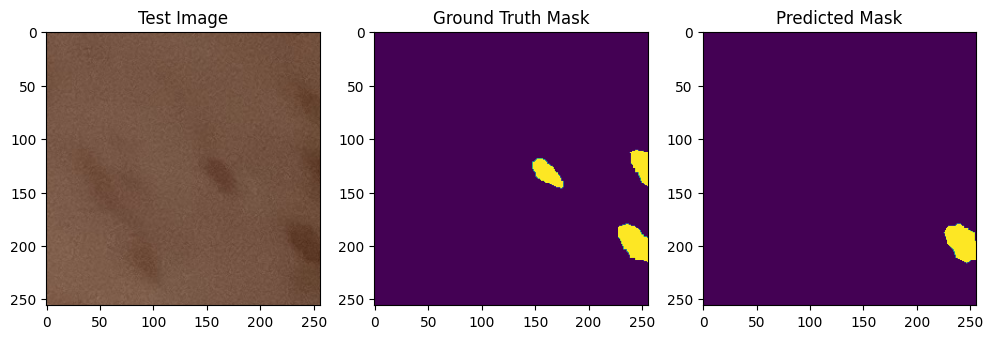

Index: 39
IOU SCORE in 100%: IoU=52.64970016479492
DICE SCORE in 100%: Dice=82.86779022216797


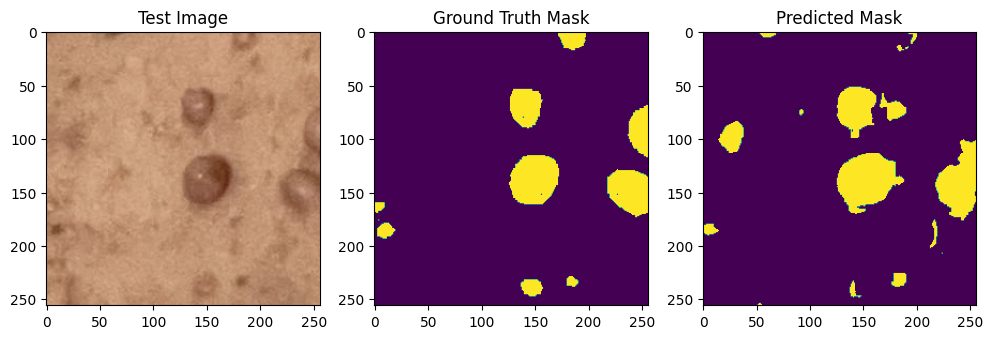

Index: 40
IOU SCORE in 100%: IoU=46.964080810546875
DICE SCORE in 100%: Dice=80.22126770019531


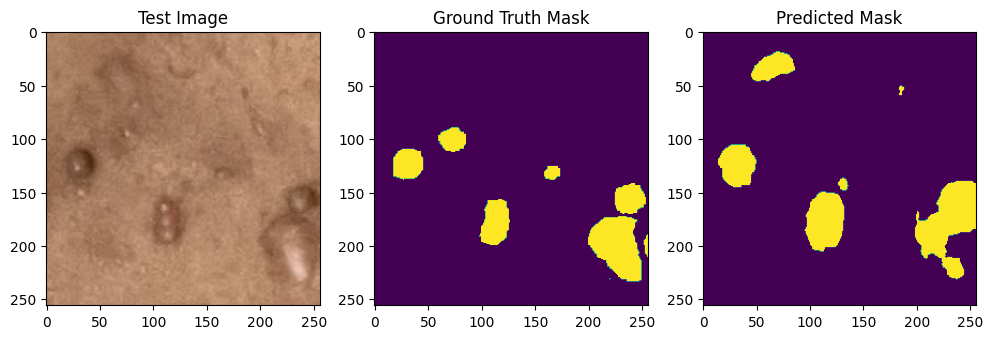

Index: 41
IOU SCORE in 100%: IoU=49.015254974365234
DICE SCORE in 100%: Dice=81.36528778076172


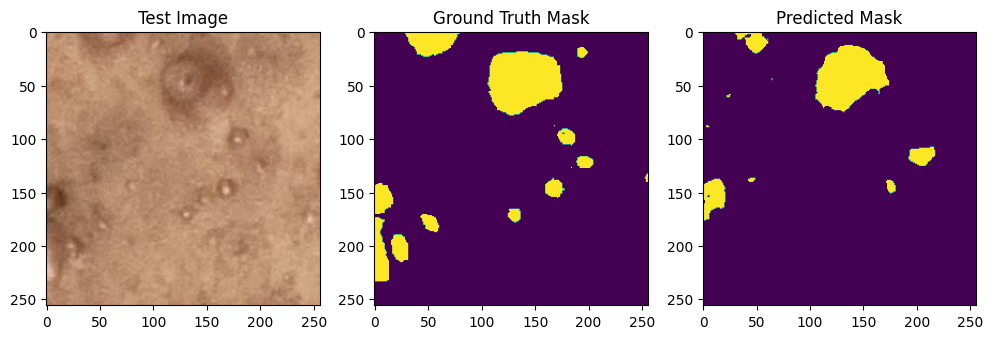

Index: 42
IOU SCORE in 100%: IoU=49.90384292602539
DICE SCORE in 100%: Dice=78.24502563476562


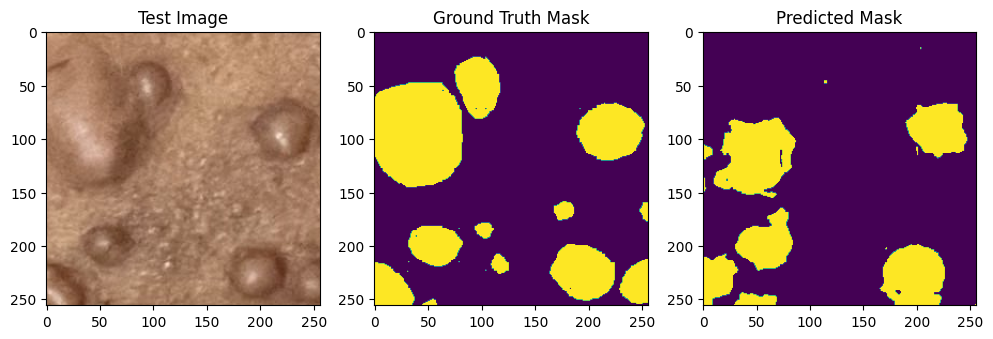

Index: 43
IOU SCORE in 100%: IoU=59.98380661010742
DICE SCORE in 100%: Dice=85.00727081298828


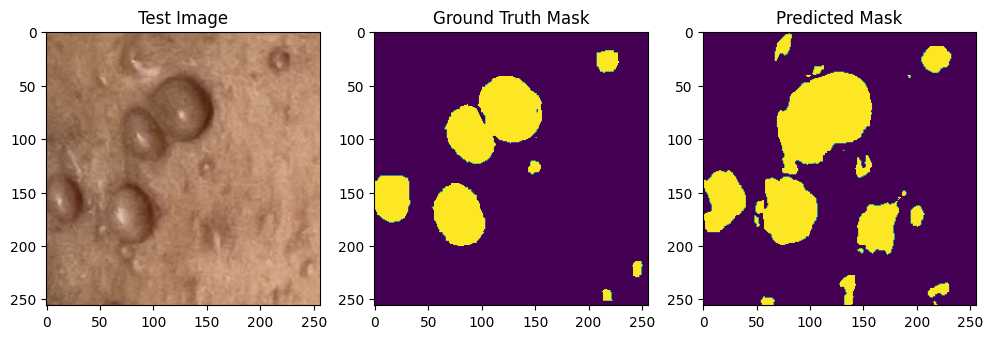

Index: 44
IOU SCORE in 100%: IoU=33.57823181152344
DICE SCORE in 100%: Dice=73.12437438964844


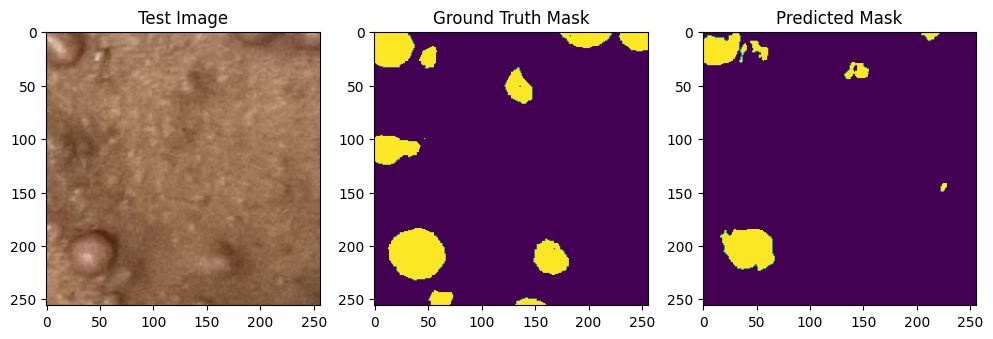

Index: 45
IOU SCORE in 100%: IoU=65.90330505371094
DICE SCORE in 100%: Dice=88.77466583251953


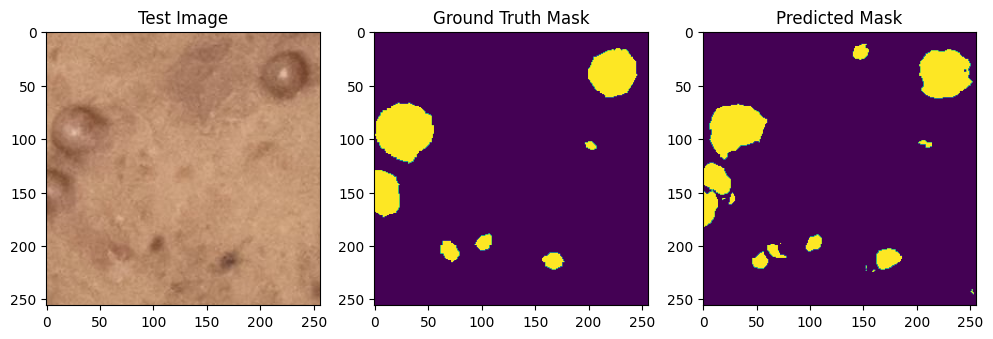

Index: 46
IOU SCORE in 100%: IoU=48.0234375
DICE SCORE in 100%: Dice=79.83991241455078


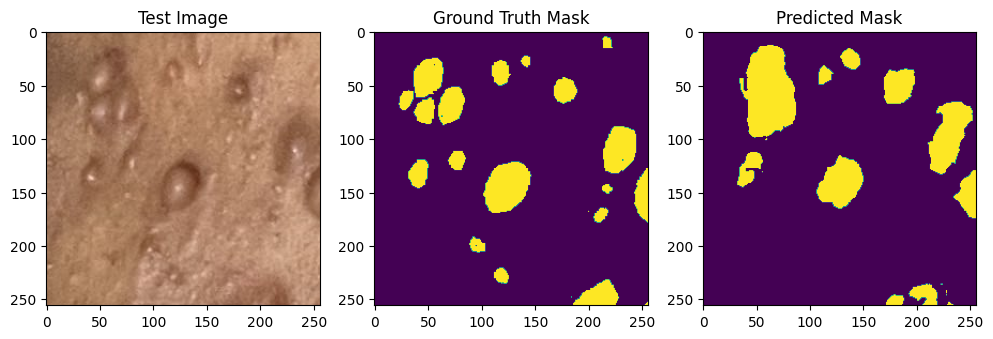

Index: 47
IOU SCORE in 100%: IoU=52.99666976928711
DICE SCORE in 100%: Dice=82.42047119140625


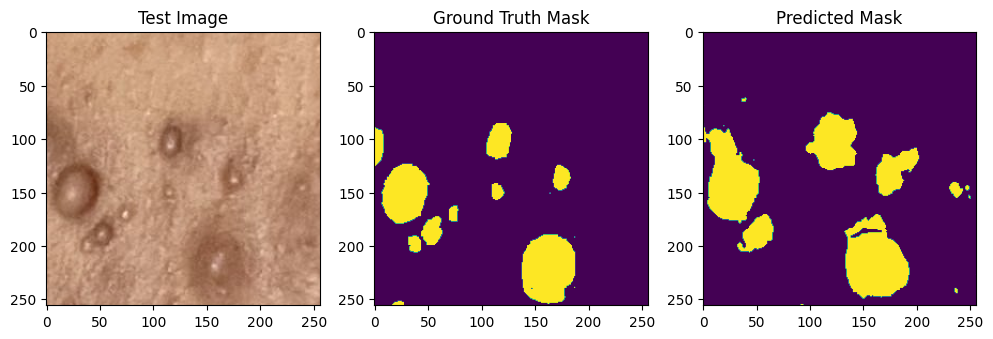

Index: 48
IOU SCORE in 100%: IoU=23.839710235595703
DICE SCORE in 100%: Dice=64.84970092773438


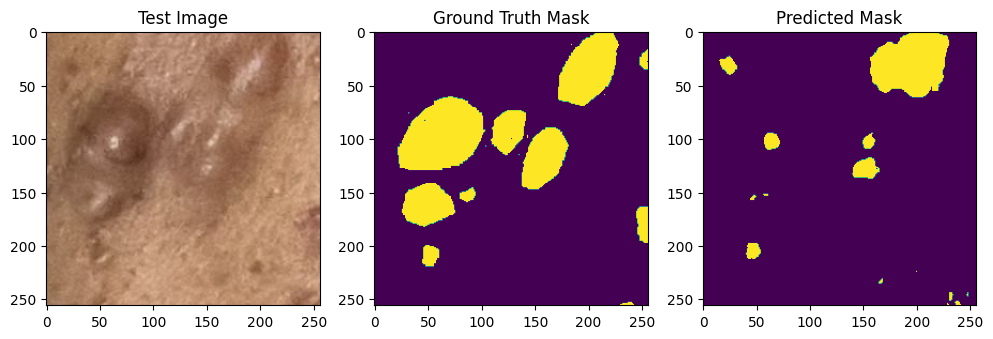

Index: 49
IOU SCORE in 100%: IoU=67.1469955444336
DICE SCORE in 100%: Dice=88.38369750976562


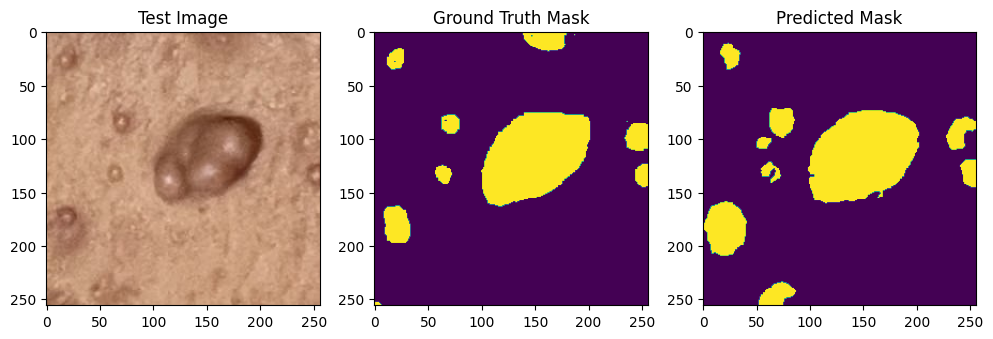

Index: 50
IOU SCORE in 100%: IoU=41.29161071777344
DICE SCORE in 100%: Dice=77.39433288574219


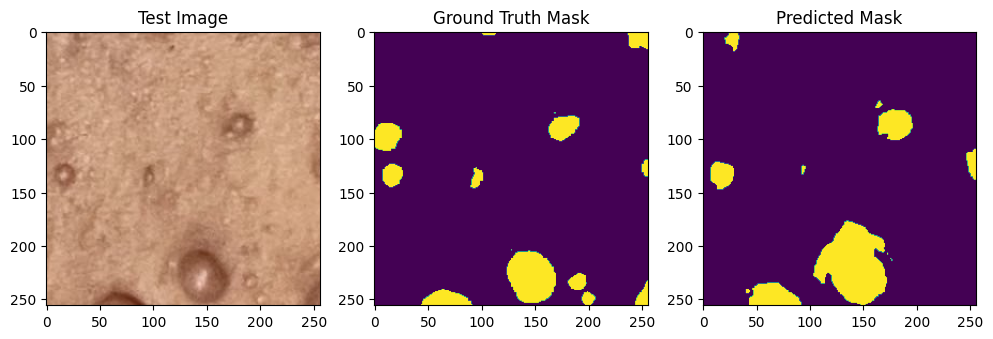

Index: 51
IOU SCORE in 100%: IoU=48.29688262939453
DICE SCORE in 100%: Dice=79.30206298828125


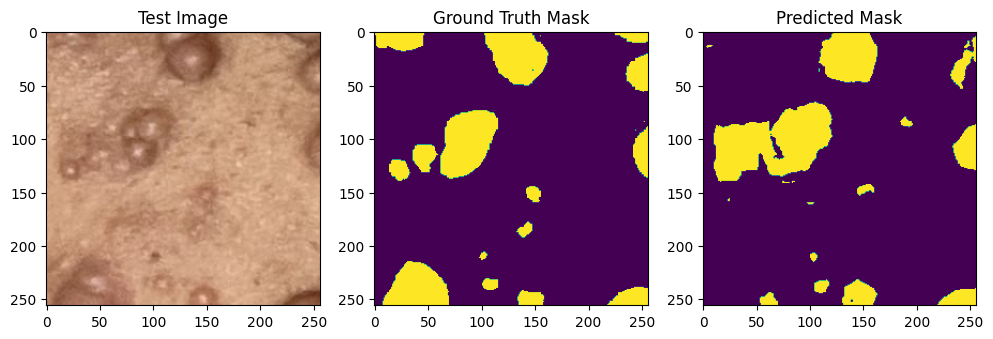

Index: 52
IOU SCORE in 100%: IoU=43.74756622314453
DICE SCORE in 100%: Dice=75.63134002685547


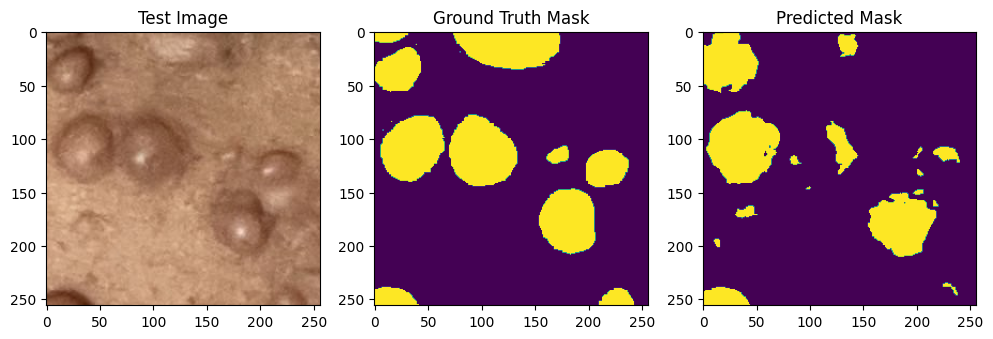

Index: 53
IOU SCORE in 100%: IoU=47.851356506347656
DICE SCORE in 100%: Dice=79.77354431152344


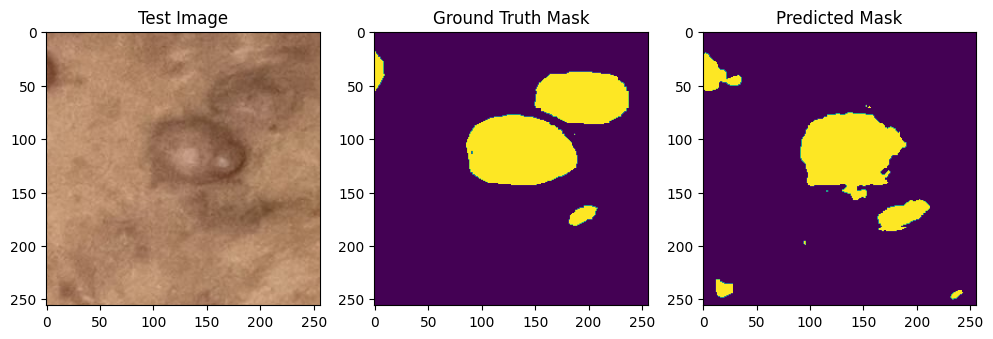

Index: 54
IOU SCORE in 100%: IoU=86.45735931396484
DICE SCORE in 100%: Dice=96.25474548339844


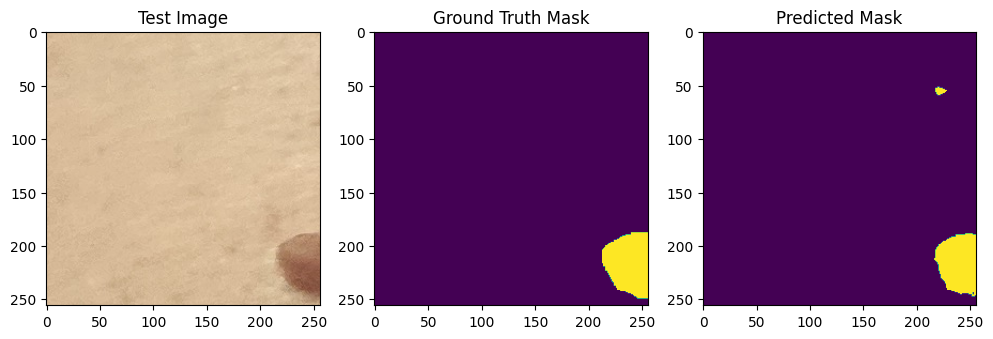

Index: 55
IOU SCORE in 100%: IoU=80.10298156738281
DICE SCORE in 100%: Dice=94.26182556152344


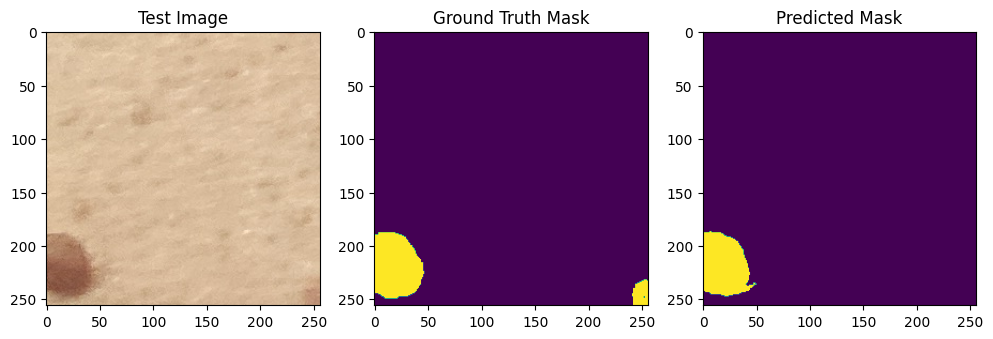

Index: 56
IOU SCORE in 100%: IoU=66.89419555664062
DICE SCORE in 100%: Dice=90.04466247558594


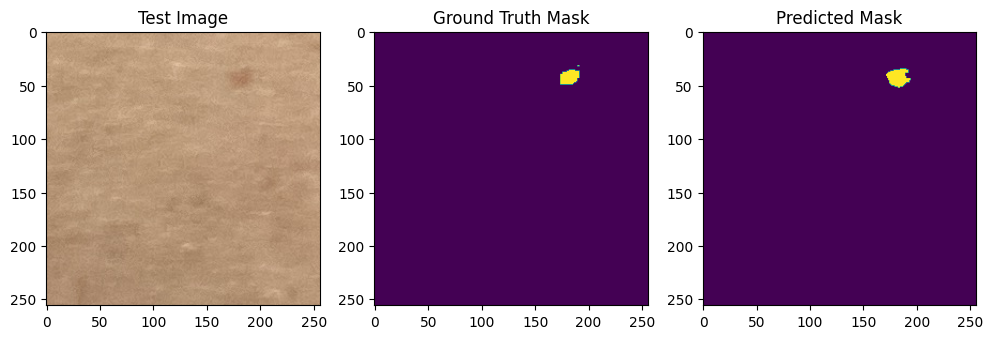

Index: 57
IOU SCORE in 100%: IoU=75.52941131591797
DICE SCORE in 100%: Dice=92.98958587646484


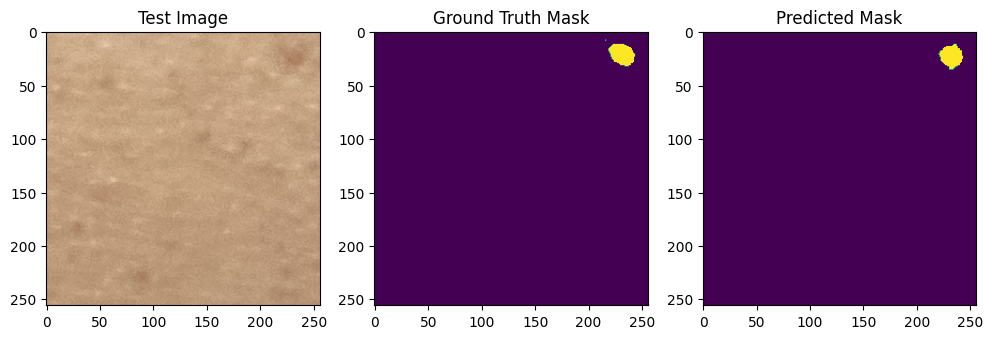

Index: 58
IOU SCORE in 100%: IoU=78.63849639892578
DICE SCORE in 100%: Dice=93.9507827758789


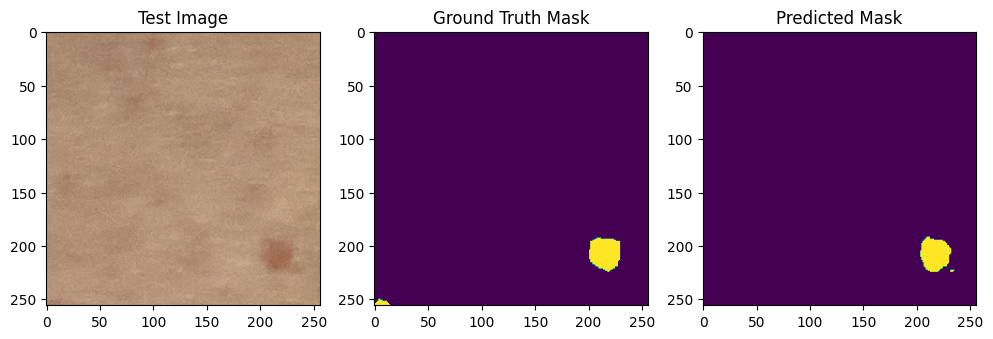

Index: 59
IOU SCORE in 100%: IoU=62.986839294433594
DICE SCORE in 100%: Dice=88.09417724609375


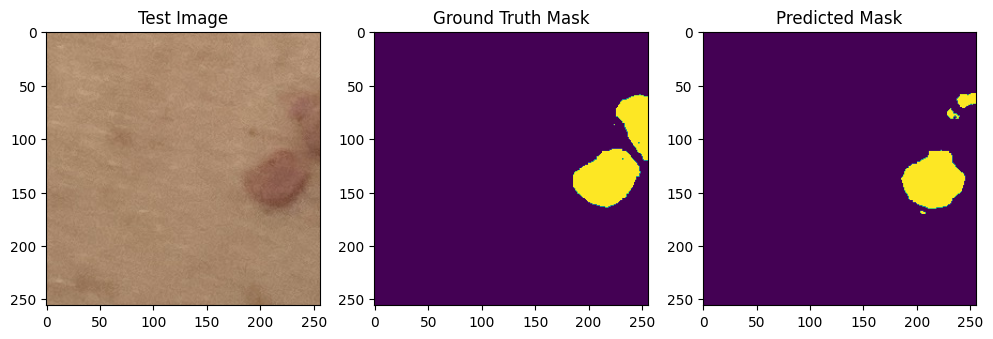

Index: 60
IOU SCORE in 100%: IoU=50.65963363647461
DICE SCORE in 100%: Dice=82.9570083618164


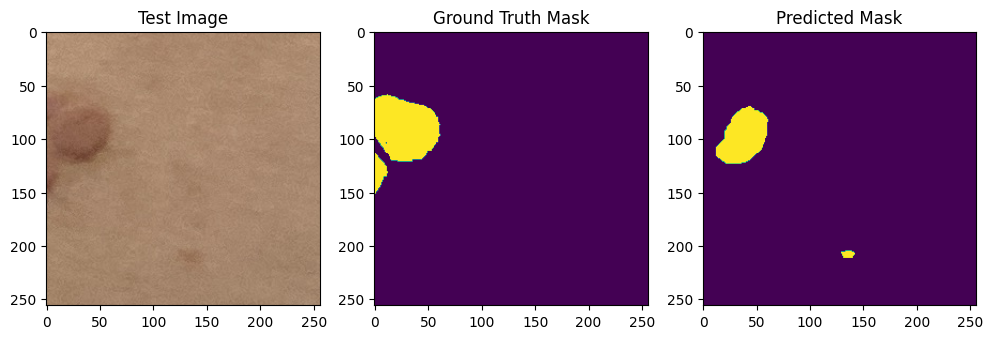

Index: 61
IOU SCORE in 100%: IoU=75.97254180908203
DICE SCORE in 100%: Dice=93.13265991210938


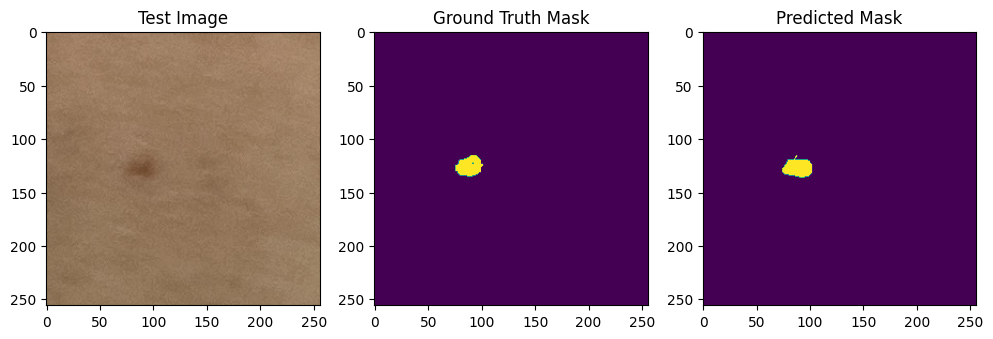

Index: 62
IOU SCORE in 100%: IoU=56.93219757080078
DICE SCORE in 100%: Dice=85.10511779785156


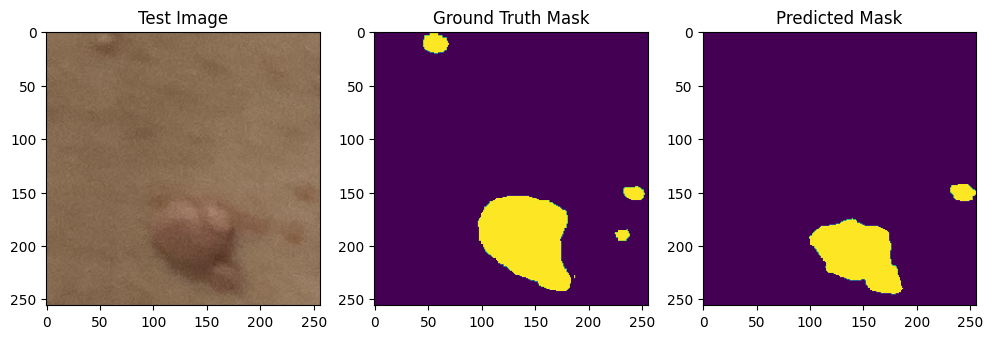

In [24]:

# Run in evaluation mode
model.eval()
with torch.no_grad():
    for idx in range(63): # Loop through all indices in the val_dataset
        x, y = val_dataset[idx]  # Read image x and true_mask y from test dataset
        normalized_image = x  # x was normalized in the dataset
        true_mask = y
        
        # Need to unsqueeze tensor x to have dimension of tensor: 1, BS, H, W for processing
        image = x.to(device).float().unsqueeze(0)
        
        # Pass to device and process by trained model
        pre_mask = model(image).squeeze()  # (1,1,H,W) to (H,W)
        predicted_mask = pre_mask.float()
        predicted_mask = predicted_mask.sigmoid().round().long()
        
        # Measure IOU and DICE for each test image patch
        dice_score = dice_function(predicted_mask, y.long())
        iou_score = iou_function(predicted_mask, y.long())
        
        # Turn the IOU and DICE scores into percentage units
        iou_score = iou_score * 100
        dice_score = dice_score * 100
        
        # Plot the figure with Test Image, Ground Truth Mask, and Predicted Mask
        # Unnormalize the normalized image patch from the dataset
        original_image = unorm(normalized_image)
        
        # Change the order of tensor dimensions to [H, W, C] (Height, Width, Channels)
        original_image = original_image.permute(1, 2, 0)
        
        # Convert to NumPy arrays for further processing
        original_image = original_image.numpy()
        
        BOLD = "\033[1m"
        RESET = "\033[0m"
        
        print(f"Index: {idx}")
        print("IOU SCORE in 100%: {}IoU={}{}".format(BOLD, iou_score, RESET))
        print("DICE SCORE in 100%: {}Dice={}{}".format(BOLD, dice_score, RESET))
        
        # Plot the original test image patch
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)  # x(GPU) to x(CPU)
        plt.title("Test Image")
        
        # Plot the ground truth mask patch
        plt.subplot(1, 3, 2)
        plt.imshow(y)
        plt.title("Ground Truth Mask")
        
        # Plot the predicted patch
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask.cpu())
        plt.title("Predicted Mask")
        
        plt.show()
